# Import libraries

In [2]:
import scipy as sc
from scipy.integrate import odeint, solve_bvp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import pyccl as ccl
from mpl_toolkits import mplot3d
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
import corner
from joblib import Parallel, delayed
from datetime import datetime
from tqdm import tqdm

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes 
from mpl_toolkits.axes_grid1.inset_locator import inset_axes 
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

## Useful info

In [3]:
""" matter_power_spectrum_types = {
    'halo_model':   lib.halo_model,
    'halofit':      lib.halofit,
    'linear':       lib.linear,
    'emu':          lib.emu
}
"""

" matter_power_spectrum_types = {\n    'halo_model':   lib.halo_model,\n    'halofit':      lib.halofit,\n    'linear':       lib.linear,\n    'emu':          lib.emu\n}\n"

# Add real data

In [4]:
# --- ADD OUR DATA for fsigma_8 ----

z_data = [0.02,0.067,0.1,0.17,0.35,0.77,0.25,0.37,0.22,0.41,0.6,0.6,0.78,0.57,0.3,0.4,0.5,0.8]
fsigma8_data = [0.36,0.423,0.37,0.51,0.44,0.49,0.351,0.46,0.42,0.45,0.43,0.433,0.38,0.427,0.407,0.419,0.427,0.47]
err_data = [0.04,0.055,0.13,0.06,0.05,0.18,0.058,0.038,0.07,0.04,0.04,0.067,0.04,0.066,0.055,0.041,0.043,0.08]

# Find Delta(a) and sigma8

## Define useful functions for growth


In [5]:
# Define xi, caracteristic function of 4DEGB. xi(alpha_C = 1) = 1
# note: k is unitless (ie. k is actually k/H0)
def xi(a, cosmo1, k):
    Omega_c , Omega_b , Omega_k , Omega_r , alpha_C = cosmo1
    if alpha_C == 0:
        return 1
    else:
        Omega_m = Omega_c + Omega_b
        Omega_lambda = 1 - Omega_m - Omega_r - Omega_k - alpha_C
        return (k**2)*a**2/((k**2)*a**2 + 6*alpha_C)

# Define Ea^2 = H/H0 a^2 (a suqared to avoid singularity
def Easquared(a,cosmo1):
    Omega_c , Omega_b , Omega_k , Omega_r , alpha_C = cosmo1
    Omega_m = Omega_c + Omega_b
    Omega_lambda = 1 - Omega_m - Omega_r - Omega_k - alpha_C
    
    return np.sqrt(Omega_m*a + (Omega_r + alpha_C) + Omega_k*a**(2) + Omega_lambda*a**(4))

# FUNCTIONS FOR BVP

# Second order ODE for D_+(a)
def solverGrowth(a, y, cosmo1, k):
    Omega_c = cosmo1[0]
    Omega_b = cosmo1[1]
    Omega_m = Omega_c + Omega_b
    Easq_val = Easquared(a, cosmo1)
    D , a3EdDda = y
    return np.vstack(((a3EdDda / (Easq_val*a)), 3*Omega_m*D*xi(a, cosmo1, k)/(2*Easq_val)))

# BC for our ODE. D(a=0) = 0, D(a = 1) = 1
# can set value of either function (y[0] or y[1]) at the lower (a) or upper (b) limit
def bc(ya, yb):
    return np.array([ya[0], yb[0] - 1])

# Function that returns D, f for a given cosmo, a and k
def solve_for_growth(a, cosmo1, k):
    
    # x range over which to solve fun
    x = np.logspace(-20,0,100)
    # initial guess for value of functions (y_init = [y[0]_init,y[0]_init])
    y_init = np.zeros((2, x.size))
    y_init[0] = x
    D_val = np.zeros((len(k),len(a)))
    f_val = np.zeros((len(k),len(a)))
    for i in range(len(k)):
        soln = solve_bvp(lambda x, y: solverGrowth(x, y, cosmo1, k[i]), bc, x, y_init).sol(a)
        D_val[i] = soln[0]
        a3EDdot = soln[1]
        f_val[i] = a3EDdot/(D_val[i]*Easquared(a,cosmo1))
    return D_val, f_val

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx


# Define cosmology and scales

In [6]:
# ---- COSMOLOGY, SCALES AND BOUNDARY CONDITIONS -----

# note: k is unitless (ie. k is actually k/H0)
# for simga_8, k = 2pi/(8h^-1 Mpc) \implies k/H0 = 3e5*pi/400

k_val = np.logspace(-3, -0.1, 300)*(3e5/100)

# Decide on some coordinate times
x_val = np.linspace( -2, 0 , 100)
a_val = np.exp(x_val)
z_val = 1/a_val - 1

# Decide on some background cosmology = Omega_c , Omega_b , Omega_k , Omega_r , alpha_C
cosmo_LCDM_array = [0.27 , 0.045, 0 ,9.227e-5 , 0.0]
cosmo = [0.27 , 0.045, 0 ,9.227e-5 , 1e-5]

# Background cosmology for pyccl
cosmoLCDM = ccl.core.Cosmology(Omega_c=cosmo[0],
                               Omega_b=cosmo[1], 
                               sigma8=0.81,
                               h = 0.67,
                               n_s=0.96,
                               Omega_k=cosmo[2], 
                               Omega_g=cosmo[3])

idx_sigma = find_nearest(k_val, 3e5*np.pi/400)
print("error in k_simga8 = ", 100*abs(3e5*np.pi/400 - k_val[idx_sigma])/(3e5*np.pi/400), "%")

error in k_simga8 =  1.0966226839201332 %


# Get plots for D+, f and fsigma8

In [48]:
solution_growth = solve_for_growth(a_val, cosmo, k_val)
solution_growth_LCDM = solve_for_growth(a_val, cosmo_LCDM_array, k_val)
# get LCDM for only some values of k for the plot to compare to 4DEGB
k_ex1 = k_val[int(len(k_val)/2)-5: int(len(k_val)/2) + 5]
solution_growth_LCDM_ex1 = solve_for_growth(a_val, cosmo_LCDM_array, k_ex1)

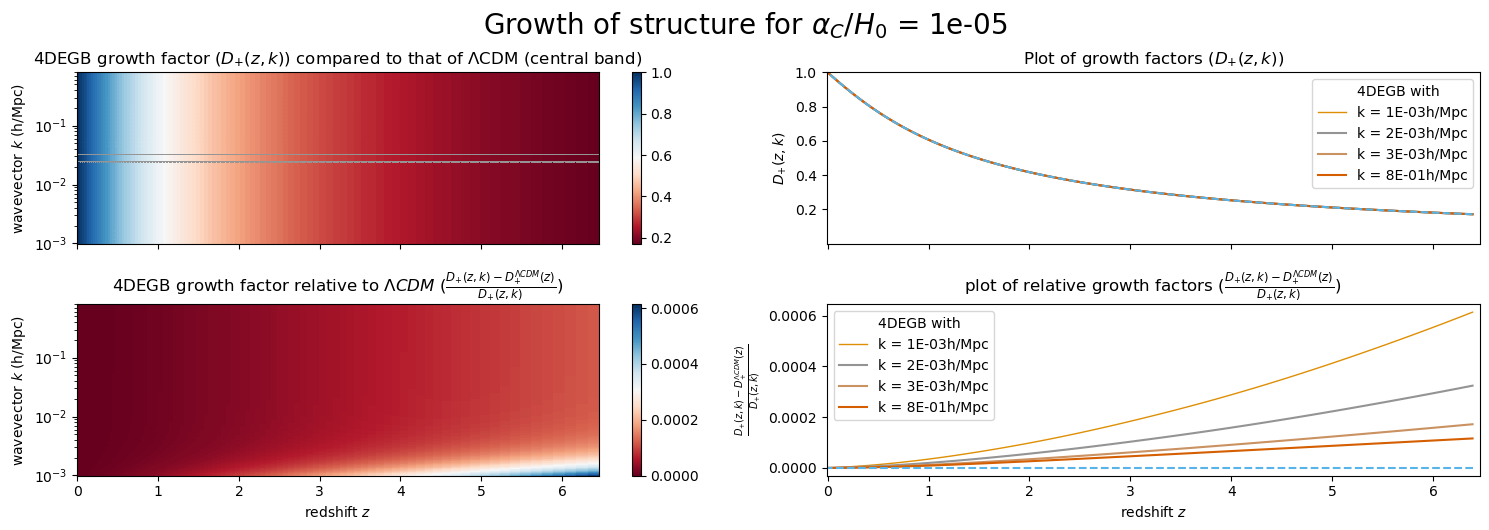

In [49]:
"""Linear Growth factor D+(a) plots"""

fig, axs = plt.subplots(2, 2, figsize=(15, 5), sharex=True)

col = sns.color_palette("colorblind") 
# best combinations are 0,2,4,9 and 1,3,5,8. Grey is 7

# X AND Y AXIS VALUES USED
# Full k space
X, Y = np.meshgrid(z_val, k_val/(3e5/100))
# reduced k space for LCDM example
X_ex1, Y_ex1 = np.meshgrid(z_val, k_ex1/(3e5/100))
# k space for black lines
X_blackline, Y_blackline = np.meshgrid(z_val, [k_val[int(len(k_val)/2)-7]/(3e5/100),k_val[int(len(k_val)/2)-6]/(3e5/100)])
X_blackline1, Y_blackline1 = np.meshgrid(z_val, [k_val[int(len(k_val)/2)+5]/(3e5/100),k_val[int(len(k_val)/2)+6]/(3e5/100)])
# k value for 8 Mpc/h
X_8, Y_8 = np.meshgrid(z_val, [np.pi/4+0.005, np.pi/4 -0.005])
# CMB value
X_CMB, Y_CMB = np.meshgrid([1/1101 - 1e-6, 1/1101 + 1e-6] , k_val/(3e5/100))

# PLOT OF RELATIVE D+(a)
ax = axs[1][0]
Z = (solution_growth[0]-solution_growth_LCDM[0])/solution_growth[0]
c = ax.pcolor(X, Y, Z,vmin=Z.min(), vmax=Z.max(), alpha = 1, cmap='RdBu')
ax.set_title(r'4DEGB growth factor relative to $\Lambda CDM$ ($\frac{D_{+}(z,k) - D_{+}^{\Lambda CDM}(z)}{D_{+}(z,k)}$)')
ax.set_ylabel(r'wavevector $k$ (h/Mpc)')
# Line for CMB
#c2 = ax.pcolor(X_CMB, Y_CMB, np.zeros((len(k_val),2)), vmin=-10, vmax=0, alpha = 0.5, cmap='Greys')
#ax.text(1e-3, 0.5, r"CMB")
fig.colorbar(c, ax=ax)
ax.set_yscale("log")
ax.set_xlabel(r'redshift $z$')

# PLOTS OF D+(a) OF 4DEGB AND LCDM
ax = axs[0][0]
Z = solution_growth[0]
# Plot of 4DEGB growth rate
c = ax.pcolor(X, Y, Z, vmin=Z.min(), vmax=Z.max(), alpha = 1, cmap='RdBu')
# Line to help distinguish LCDM and 4DEGB
c2 = ax.pcolor(X_blackline, Y_blackline, np.zeros((2,len(z_val))), vmin=-10, vmax=10, alpha = 1, cmap='Greys')
c2 = ax.pcolor(X_blackline1, Y_blackline1, np.zeros((2,len(z_val))), vmin=-10, vmax=10, alpha = 1, cmap='Greys')
# An example of LCDM equivalent plots
c1 = ax.pcolor(X_ex1, Y_ex1, solution_growth_LCDM_ex1[0],vmin=Z.min(), vmax=Z.max(), \
              alpha = 1, cmap='RdBu')
# Line for 8 Mpc/h ---- TODO ------------------------------------------------------------------------------------
#c2 = ax.pcolor(X_8, Y_8, np.zeros((2,len(z_val))), vmin=-10, vmax=0, alpha = 0.5, cmap='Greys')
#ax.text(0.15, 8e3, r"$k = 8 Mpc/h$")
# Line for CMB
#c2 = ax.pcolor(X_CMB, Y_CMB, np.zeros((len(k_val),2)), vmin=-10, vmax=0, alpha = 0.5, cmap='Greys')
#ax.text(1e-3, 0.5, r"CMB")

ax.set_title(r'4DEGB growth factor ($D_{+}(z,k)$) compared to that of $\Lambda$CDM (central band)')
ax.set_ylabel(r'wavevector $k$ (h/Mpc)')
ax.set_yscale("log")
fig.colorbar(c, ax=ax)

# 2D PLOTS OF D+(a)
ax = axs[0][1]
ax.plot(1,0, alpha = 0, label = "4DEGB with")
ax.plot(z_val, Z[0], label = "k = {:.0E}h/Mpc".format(k_val[0]/3000), linewidth =1, color = col[1])
ax.plot(z_val, Z[-280], label = "k = {:.0E}h/Mpc".format(k_val[-280]/3000), color = col[7])
ax.plot(z_val, Z[-250], label = "k = {:.0E}h/Mpc".format(k_val[-250]/3000), color = col[5])
ax.plot(z_val, Z[-1], label = "k = {:.0E}h/Mpc".format(k_val[-1]/3000), color = col[3])
ax.plot(z_val, solution_growth_LCDM[0][int(len(k_val)/2)], color = col[9], linestyle = "--")
#CMB
#ax.plot(1/1101*np.ones(len(z_val)), np.linspace(0,1,len(z_val)), linestyle = "--", color = "k")
#ax.text(1e-3, 0.5, r"CMB")

#ax.text(1e-4, 0.2e-3, r"$\Lambda CDM$")
ax.set_ylabel(r"$D_{+}(z,k)$")
ax.set_ylim(1e-4,1)
ax.set_title(r'Plot of growth factors ($D_{+}(z,k)$)')
ax.legend()

# 2D PLOTS OF RELATIVE D+(a)
ax = axs[1][1]
ax.plot(1,0, alpha = 0, label = "4DEGB with")
Z = (solution_growth[0]-solution_growth_LCDM[0])/solution_growth[0]
ax.plot(z_val, Z[0], label = "k = {:.0E}h/Mpc".format(k_val[0]/3000), linewidth =1, color = col[1])
ax.plot(z_val, Z[-280], label = "k = {:.0E}h/Mpc".format(k_val[-280]/3000), color = col[7])
ax.plot(z_val, Z[-250], label = "k = {:.0E}h/Mpc".format(k_val[-250]/3000), color = col[5])
ax.plot(z_val, Z[-1], label = "k = {:.0E}h/Mpc".format(k_val[-1]/3000), color = col[3])
ax.plot(z_val, np.zeros(len(z_val)), color = col[9], linestyle = "--")
#CMB
#ax.plot(1/1101*np.ones(len(z_val)), np.linspace(0,1,len(z_val)), linestyle = "--", color = "k")
#ax.text(1e-3, 0.9, r"CMB")

#ax.plot(z_val, solution_growth_LCDM[0][int(len(k_val)/2)], label = "LCDM", color = col[9])
ax.legend()
ax.set_title(r'plot of relative growth factors ($\frac{D_{+}(z,k) - D_{+}^{\Lambda CDM}(z)}{D_{+}(z,k)}$)')
ax.set_ylabel(r"$\frac{D_{+}(z,k) - D_{+}^{\Lambda CDM}(z)}{D_{+}(z,k)}$")
ax.set_xlabel(r"redshift $z$")
#plt.pcolor(X_LCDM, Y_LCDM, np.zeros((len(k_val[450:550]),len(z_val))))
fig.tight_layout()
fig.suptitle(r'Growth of structure for $\alpha_C/H_0$ = {}'.format(cosmo[-1]), fontsize=20, y=1.05)
plt.show()

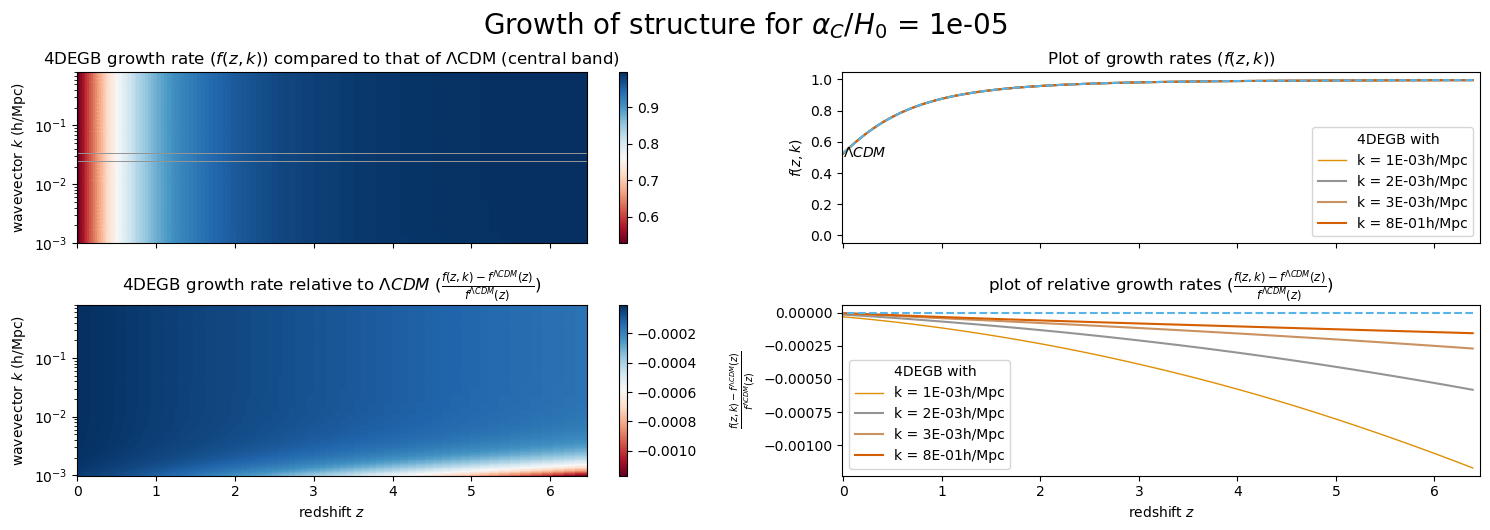

In [7]:
"""Linear Growth rate f(a) plots"""
fig, axs = plt.subplots(2, 2, figsize=(15, 5), sharex=True)

col = sns.color_palette("colorblind") 
# best combinations are 0,2,4,9 and 1,3,5,8. Grey is 7

# X AND Y AXIS VALUES USED
# Full k space
X, Y = np.meshgrid(z_val, k_val/3000)
# reduced k space for LCDM example
X_ex1, Y_ex1 = np.meshgrid(z_val, k_ex1/3000)
# k space for black lines
X_blackline, Y_blackline = np.meshgrid(z_val, [k_val[int(len(k_val)/2)-7]/3000,k_val[int(len(k_val)/2)-6]/3000])
X_blackline1, Y_blackline1 = np.meshgrid(z_val, [k_val[int(len(k_val)/2)+5]/3000,k_val[int(len(k_val)/2)+6]/3000])
# k value for 8 Mpc/h
X_8, Y_8 = np.meshgrid(z_val, [3e5*np.pi/400+0.5, 3e5*np.pi/400 -0.5])
# CMB value
X_CMB, Y_CMB = np.meshgrid([1/1101 - 1e-6, 1/1101 + 1e-6] , k_val/3000)

# PLOT OF RELATIVE f(a)
ax = axs[1][0]
Z = (solution_growth[1]-solution_growth_LCDM[1])/solution_growth[1]
c = ax.pcolor(X, Y, Z,vmin=Z.min(), vmax=Z.max(), alpha = 1, cmap='RdBu')
ax.set_title(r'4DEGB growth rate relative to $\Lambda CDM$ ($\frac{f(z,k) - f^{\Lambda CDM}(z)}{f^{\Lambda CDM}(z)}$)')
ax.set_ylabel(r'wavevector $k$ (h/Mpc)')
# Line for CMB
#c2 = ax.pcolor(X_CMB, Y_CMB, np.zeros((len(k_val),2)), vmin=-10, vmax=0, alpha = 0.5, cmap='Greys')
#ax.text(1e-3, 0.5, r"CMB")
fig.colorbar(c, ax=ax)
ax.set_yscale("log")
ax.set_xlabel(r'redshift $z$')

# PLOTS OF f(a) OF 4DEGB AND LCDM
ax = axs[0][0]
Z = solution_growth[1]
# Plot of 4DEGB growth factor
c = ax.pcolor(X, Y, Z, vmin=Z.min(), vmax=Z.max(), alpha = 1, cmap='RdBu')
# Black line to help distinguish LCDM and 4DEGB
c2 = ax.pcolor(X_blackline, Y_blackline, np.zeros((2,len(z_val))), vmin=-10, vmax=10, alpha = 1, cmap='Greys')
c2 = ax.pcolor(X_blackline1, Y_blackline1, np.zeros((2,len(z_val))), vmin=-10, vmax=10, alpha = 1, cmap='Greys')
# An example of LCDM equivalent plots
c1 = ax.pcolor(X_ex1, Y_ex1, solution_growth_LCDM_ex1[1],vmin=Z.min(), vmax=Z.max(), \
              alpha = 1, cmap='RdBu')
# Line for 8 Mpc/h
#c2 = ax.pcolor(X_8, Y_8, np.zeros((2,len(z_val))), vmin=-10, vmax=0, alpha = 0.5, cmap='Greys')
#ax.text(0.15, 8e3, r"$k = 8 Mpc/h$")
# Line for CMB
#c2 = ax.pcolor(X_CMB, Y_CMB, np.zeros((len(k_val),2)), vmin=-10, vmax=0, alpha = 0.5, cmap='Greys')
#ax.text(1e-3, 0.5, r"CMB")

ax.set_title(r'4DEGB growth rate ($f(z,k)$) compared to that of $\Lambda$CDM (central band)')
ax.set_ylabel(r'wavevector $k$ (h/Mpc)')
ax.set_yscale("log")
fig.colorbar(c, ax=ax)

# 2D PLOTS OF f(a)
ax = axs[0][1]
ax.plot(1,0, alpha = 0, label = "4DEGB with")
ax.plot(z_val, Z[0], label = "k = {:.0E}h/Mpc".format(k_val[0]/3000), linewidth =1, color = col[1])
ax.plot(z_val, Z[-280], label = "k = {:.0E}h/Mpc".format(k_val[-280]/3000), color = col[7])
ax.plot(z_val, Z[-250], label = "k = {:.0E}h/Mpc".format(k_val[-250]/3000), color = col[5])
ax.plot(z_val, Z[-1], label = "k = {:.0E}h/Mpc".format(k_val[-1]/3000), color = col[3])
ax.plot(z_val, solution_growth_LCDM[1][int(len(k_val)/2)], color = col[9], linestyle = "--")
ax.text(0.7e-4, 0.5, r"$\Lambda CDM$")
#CMB
#ax.plot(1/1101*np.ones(len(z_val)), np.linspace(0,1,len(z_val)), linestyle = "--", color = "k")
#ax.text(1e-3, 0.5, r"CMB")

ax.set_ylabel(r"$f(z,k)$")
ax.set_title(r'Plot of growth rates ($f(z,k)$)')
ax.legend()

# 2D PLOTS OF RELATIVE f(a)
ax = axs[1][1]
ax.plot(1,0, alpha = 0, label = "4DEGB with")
Z = (solution_growth[1]-solution_growth_LCDM[1])/solution_growth_LCDM[1]
ax.plot(z_val, Z[0], label = "k = {:.0E}h/Mpc".format(k_val[0]/3000), linewidth =1, color = col[1])
ax.plot(z_val, Z[-280], label = "k = {:.0E}h/Mpc".format(k_val[-280]/3000), color = col[7])
ax.plot(z_val, Z[-250], label = "k = {:.0E}h/Mpc".format(k_val[-250]/3000), color = col[5])
ax.plot(z_val, Z[-1], label = "k = {:.0E}h/Mpc".format(k_val[-1]/3000), color = col[3])
ax.plot(z_val, np.zeros(len(z_val)), color = col[9], linestyle = "--")
#CMB
#ax.plot(1/1101*np.ones(len(a_val)), np.linspace(-1,0,len(a_val)), linestyle = "--", color = "k")
#ax.text(1e-3, -0.5, r"CMB")

#ax.plot(z_val, solution_growth_LCDM[0][int(len(k_val)/2)], label = "LCDM", color = col[9])
ax.legend()
ax.set_title(r'plot of relative growth rates ($\frac{f(z,k) - f^{\Lambda CDM}(z)}{f^{\Lambda CDM}(z)}$)')
ax.set_ylabel(r"$\frac{f(z,k) - f^{\Lambda CDM}(z)}{f^{\Lambda CDM}(z)}$")
ax.set_xlabel(r"redshift $z$")
#plt.pcolor(X_LCDM, Y_LCDM, np.zeros((len(k_val[450:550]),len(a_val))))
fig.tight_layout()
fig.suptitle(r'Growth of structure for $\alpha_C/H_0$ = {}'.format(cosmo[-1]), fontsize=20, y=1.05)
plt.show()

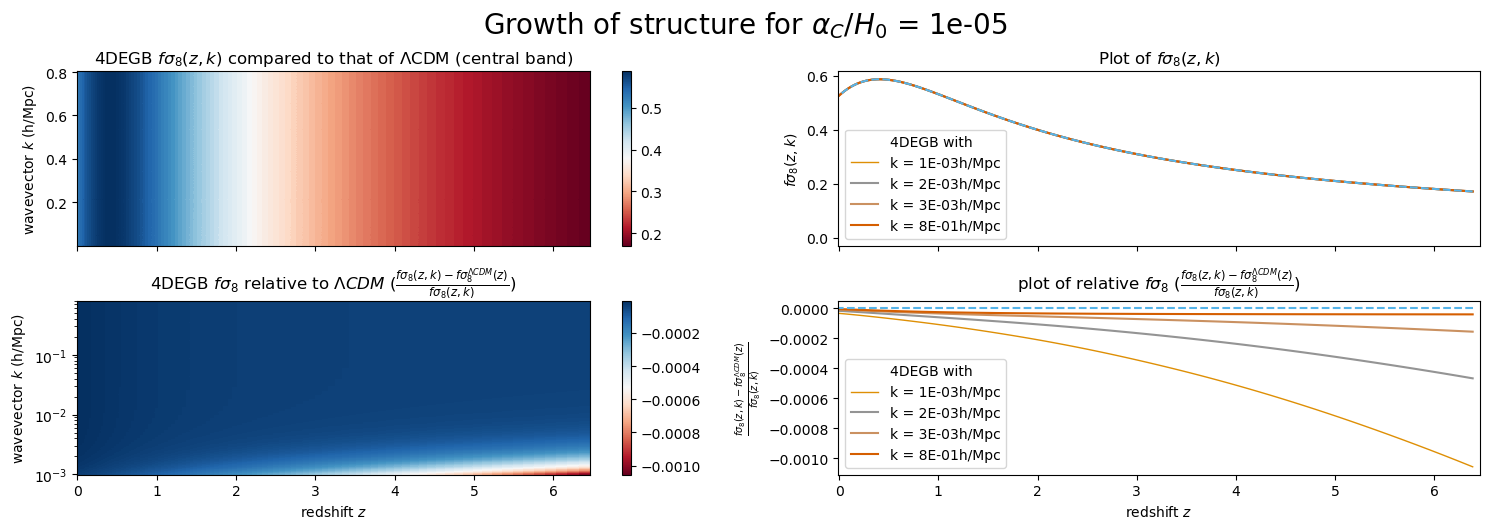

In [8]:
"""Linear fsigma8 plots"""
fig, axs = plt.subplots(2, 2, figsize=(15, 5), sharex=True)

col = sns.color_palette("colorblind")
# best combinations are 0,2,4,9 and 1,3,5,8. Grey is 7

# X AND Y AXIS VALUES USED
# Full k space
X, Y = np.meshgrid(z_val, k_val/3000)
# reduced k space for LCDM example
X_ex1, Y_ex1 = np.meshgrid(z_val, k_ex1/3000)
# k space for black lines
X_blackline, Y_blackline = np.meshgrid(z_val, [k_val[int(len(k_val)/2)-7]/3000,k_val[int(len(k_val)/2)-6]/3000])
X_blackline1, Y_blackline1 = np.meshgrid(z_val, [k_val[int(len(k_val)/2)+5]/3000,k_val[int(len(k_val)/2)+6]/3000])
# k value for 8 Mpc/h
X_8, Y_8 = np.meshgrid(z_val, [3e5*np.pi/400+0.5, 3e5*np.pi/400 -0.5])
# CMB value
X_CMB, Y_CMB = np.meshgrid([1/1101 - 1e-6, 1/1101 + 1e-6] , k_val/3000)

# PLOT OF RELATIVE fsigma8(a,k) = f(a,k)*sigma(a, k = 8Mpc/h)
ax = axs[1][0]
Z = (solution_growth[1]*solution_growth[0][idx_sigma]-solution_growth_LCDM[1]*solution_growth_LCDM[0])/(solution_growth[1]*solution_growth[0][idx_sigma])
c = ax.pcolor(X, Y, Z,vmin=Z.min(), vmax=Z.max(), alpha = 1, cmap='RdBu')
ax.set_title(r'4DEGB $f\sigma_8$ relative to $\Lambda CDM$ ($\frac{f\sigma_8(z,k) - f\sigma_8^{\Lambda CDM}(z)}{f\sigma_8(z,k)}$)')
ax.set_ylabel(r'wavevector $k$ (h/Mpc)')
fig.colorbar(c, ax=ax)
# Line for CMB
#c2 = ax.pcolor(X_CMB, Y_CMB, np.zeros((len(k_val),2)), vmin=-10, vmax=0, alpha = 0.5, cmap='Greys')
#ax.text(1e-3, 0.5, r"CMB")

ax.set_yscale("log")
ax.set_xlabel(r'redshift $z$')

# PLOTS OF fsigma8(a,k) = f(a,k)*sigma(a, k = 8Mpc/h) FOR 4DEGB AND LCDM
ax = axs[0][0]
Z = solution_growth[1]*solution_growth[0][idx_sigma]
# Plot of 4DEGB growth rate
c = ax.pcolor(X, Y, Z, vmin=Z.min(), vmax=Z.max(), alpha = 1, cmap='RdBu')
# An example of LCDM equivalent plots
c1 = ax.pcolor(X_ex1, Y_ex1, solution_growth_LCDM_ex1[1]*solution_growth_LCDM_ex1[0],vmin=Z.min(), vmax=Z.max(), \
              alpha = 1, cmap='RdBu')
# Line for 8 Mpc/h
#c2 = ax.pcolor(X_8, Y_8, np.zeros((2,len(z_val))), vmin=-10, vmax=0, alpha = 0.5, cmap='Greys')
#ax.text(0.15, 8e3, r"$k = 8 Mpc/h$")
# Line for CMB
#c2 = ax.pcolor(X_CMB, Y_CMB, np.zeros((len(k_val),2)), vmin=-10, vmax=0, alpha = 0.5, cmap='Greys')
#ax.text(1e-3, 0.5, r"CMB")
# Black line to help distinguish LCDM and 4DEGB
#c2 = ax.pcolor(X_blackline, Y_blackline, np.zeros((2,len(z_val))), vmin=-10, vmax=10, alpha = 1, cmap='Greys')
#c2 = ax.pcolor(X_blackline1, Y_blackline1, np.zeros((2,len(z_val))), vmin=-10, vmax=10, alpha = 1, cmap='Greys')

ax.set_title(r'4DEGB $f\sigma_8(z,k)$ compared to that of $\Lambda$CDM (central band)')
ax.set_ylabel(r'wavevector $k$ (h/Mpc)')
fig.colorbar(c, ax=ax)

# 2D PLOTS OF fsigma8(a,k) = f(a,k)*sigma(a, k = 8Mpc/h)
ax = axs[0][1]
ax.plot(1,0, alpha = 0, label = "4DEGB with")
Z = solution_growth[1]*solution_growth[0][idx_sigma]
ax.plot(z_val, Z[0], label = "k = {:.0E}h/Mpc".format(k_val[0]/3000), linewidth =1, color = col[1])
ax.plot(z_val, Z[-280], label = "k = {:.0E}h/Mpc".format(k_val[-280]/3000), color = col[7])
ax.plot(z_val, Z[-250], label = "k = {:.0E}h/Mpc".format(k_val[-250]/3000), color = col[5])
ax.plot(z_val, Z[-1], label = "k = {:.0E}h/Mpc".format(k_val[-1]/3000), color = col[3])
ax.plot(z_val, solution_growth_LCDM[1][int(len(k_val)/2)]*solution_growth_LCDM[0][int(len(k_val)/2)], color = col[9], linestyle = "--")
#ax.text(1e-4, 0.5e-3, r"$\Lambda CDM$")
#CMB
#ax.plot(1/1101*np.ones(len(a_val)), np.linspace(0,1,len(a_val)), linestyle = "--", color = "k")
#ax.text(1e-3, 0.5, r"CMB")

ax.set_ylabel(r"$f\sigma_8(z,k)$")
ax.set_title(r'Plot of $f\sigma_8(z,k)$')
ax.legend()

# 2D PLOTS OF RELATIVE fsigma8(a,k) = f(a,k)*sigma(a, k = 8Mpc/h)
ax = axs[1][1]
ax.plot(1,0, alpha = 0, label = "4DEGB with")
Z = (solution_growth[1]*solution_growth[0][idx_sigma]-solution_growth_LCDM[1]*solution_growth_LCDM[0])/(solution_growth[1]*solution_growth[0][idx_sigma])
ax.plot(z_val, Z[0], label = "k = {:.0E}h/Mpc".format(k_val[0]/3000), linewidth =1, color = col[1])
ax.plot(z_val, Z[-280], label = "k = {:.0E}h/Mpc".format(k_val[-280]/3000), color = col[7])
ax.plot(z_val, Z[-250], label = "k = {:.0E}h/Mpc".format(k_val[-250]/3000), color = col[5])
ax.plot(z_val, Z[-1], label = "k = {:.0E}h/Mpc".format(k_val[-1]/3000), color = col[3])
ax.plot(z_val, np.zeros(len(a_val)), color = col[9], linestyle = "--")
#CMB
#ax.plot(1/1101*np.ones(len(a_val)), np.linspace(-50,0,len(a_val)), linestyle = "--", color = "k")
#ax.text(1e-3, -50, r"CMB")

#ax.plot(a_val, solution_growth_LCDM[0][int(len(k_val)/2)], label = "LCDM", color = col[9])
ax.legend()
ax.set_title(r'plot of relative $f\sigma_8$ ($\frac{f\sigma_8(z,k) - f\sigma_8^{\Lambda CDM}(z)}{f\sigma_8(z,k)}$)')
ax.set_ylabel(r"$\frac{f\sigma_8(z,k) - f\sigma_8^{\Lambda CDM}(z)}{f\sigma_8(z,k)}$")
ax.set_xlabel(r"redshift $z$")
#plt.pcolor(X_LCDM, Y_LCDM, np.zeros((len(k_val[450:550]),len(a_val))))
fig.tight_layout()
fig.suptitle(r'Growth of structure for $\alpha_C/H_0$ = {}'.format(cosmo[-1]), fontsize=20, y=1.05)
plt.show()

# Finding how the peak of fsigma8 varies with alpha_C

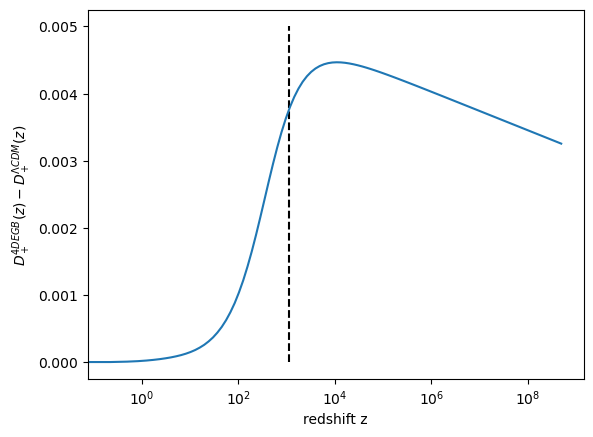

In [6]:
# Decide on some background cosmology = Omega_c , Omega_b , Omega_k , Omega_r , alpha_C
cosmo = [0.27 , 0.045, 0 ,9.227e-5 , 1e-5]
k = 0.001*(3e5/100)

# Decide on some coordinate times
x_val = np.linspace( -20, 0 , 100)
a_val = np.exp(x_val)
z_val = 1/a_val - 1
# At some characteristic scale. We choose scale k = 8 Mpc/h
solution_growth_ex = solve_for_growth(a_val, cosmo, np.array([(3e5*np.pi/400),k]))
solution_growth_LCDM_ex = solve_for_growth(a_val, cosmo_LCDM_array, np.array([1,1]))

Z = (solution_growth_ex[0]-solution_growth_LCDM_ex[0])
toeval = Z[1]

plt.plot(1101*np.ones(len(a_val)), np.linspace(0,0.005,len(a_val)), linestyle = "--", color = "k")
plt.plot(z_val, toeval)
plt.xlabel("redshift z")
plt.ylabel(r"$D_+^{4DEGB}(z) - D_+^{\Lambda CDM}(z)$")
plt.xscale("log")

# Comparing early universe and late universe S8

2.179339988853091e-06
Max predicted sigma8 from 4DEGB =  0.8157702924261218
Min predicted sigma8 from 4DEGB =  0.4156868893006981
mean1 =  0.8036423897208038
mean2 =  0.7311513209896712


/tmp/ipykernel_8354/276096387.py:40: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  avg_S8 = sc.integrate.quad(lambda x: np.interp(x, k_val, simga8_z_4DEGB_try[:,-1]),\


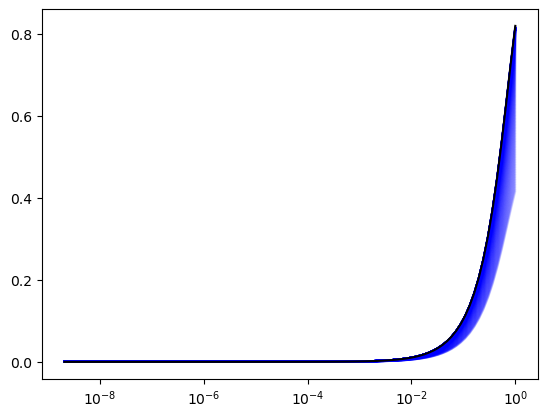

In [7]:
# All data values from
# S8 from CMB assuming LCDM (Planck) = 0.834 ± 0.016

# S8 from KiDS-450 = 0.745 ± 0.039
# S8 from KiDS-450+2dFLenS = 0.742 ± 0.035
# S8 from KV450 = 0.737^{+0.040}_{−0.036}
# S8 from DES = 0.783^{+0.021}_{−0.025}
# S8 from KiDS-1000 = = 0.766^{+0.020}_{−0.014}
N_eff = 3.15
dN_eff = N_eff - 3.046
Omg_r = (1 + (7/8) * (4/11)**(4/3)*N_eff)*9.227e-5
Omg_r_LCDM = (1 + (7/8) * (4/11)**(4/3)*3.046)*9.227e-5
cosmo = [0.27 , 0.045, 0 ,Omg_r , Omg_r - Omg_r_LCDM]
cosmo_LCDM_array = [0.27 , 0.045, 0 ,Omg_r , 0.0]

print(Omg_r - Omg_r_LCDM)
k_val = np.logspace(-3, -1, 300)*(3e5/100)
# Decide on some coordinate times
x_val = np.linspace( -20, 0 , 100)
a_val = np.exp(x_val)
z_val = 1/a_val - 1

solution_growth = solve_for_growth(a_val, cosmo, k_val)
solution_growth_LCDM = solve_for_growth(a_val, cosmo_LCDM_array, k_val)

sigma80_CMB_LCDM = 0.82
simga8_z_LCDM_try = solution_growth_LCDM[0][0]*sigma80_CMB_LCDM
simga8_atCMB_LCDM = np.interp(1/1101, a_val, simga8_z_LCDM_try)

simga8_z_4DEGB_try = np.zeros((len(k_val), len(a_val)))

for i in range(len(k_val)):
    simga8_z_4DEGB_try[i] = solution_growth[0][i]*simga8_atCMB_LCDM/\
                 np.interp(1/1101, a_val, solution_growth[0][i])
    plt.plot(a_val,simga8_z_4DEGB_try[i], color = "b", alpha = 0.1)

print("Max predicted sigma8 from 4DEGB = ",max(simga8_z_4DEGB_try[:,-1]))
print("Min predicted sigma8 from 4DEGB = ",min(simga8_z_4DEGB_try[:,-1]))

avg_S8 = sc.integrate.quad(lambda x: np.interp(x, k_val, simga8_z_4DEGB_try[:,-1]),\
                           k_val[0], k_val[-1])/((k_val[-1] - k_val[0]))

print("mean1 = ", avg_S8[0])
print("mean2 = ", np.mean(simga8_z_4DEGB_try[:,-1]))

plt.plot(a_val,simga8_z_LCDM_try, color = "black")

plt.xscale("log")


97


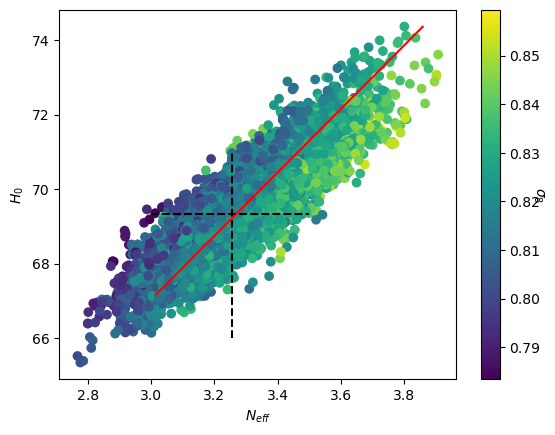

In [19]:
# Import the datafiles
content = pd.read_table('/home/c2042999/Downloads/COM_CosmoParams_fullGrid_R3.01/base_nnu/plikHM_TTTEEE_lowl_lowE_Riess18/base_nnu_plikHM_TTTEEE_lowl_lowE_Riess18_1.txt', delim_whitespace=True, header=None)

# get data for N_eff, sigma_8 and H_0
# N_eff = array[6+1], H_0 = array[30+1], sigma8 = array[36+1]

# This means the first two are probably not params, given there are 99 in total
print(len(content.T))

N_eff = content[6]
H0 = content[30]
w_b = content[2]
w_c = content[3]
sigma8 = content[36]
Omega_m_Planck = content[32]
A_s = content[44]*1e-9
n_s = content[8]

del content
fig, ax = plt.subplots()

scatter = ax.scatter(N_eff,H0, c=sigma8)
ax.plot(np.linspace(3.0,3.5,2), [0.6933350E+02,0.6933350E+02],"k--")
ax.plot([0.3256184E+01,0.3256184E+01], np.linspace(66,71,2),"k--")
ax.plot(line[:, 0], line[:, 1], 'r')
ax.set_xlabel(r"$N_{eff}$")
ax.set_ylabel(r"$H_{0}$")
cbar = fig.colorbar(scatter)
cbar.set_label(r'$\sigma_8$', rotation=270)

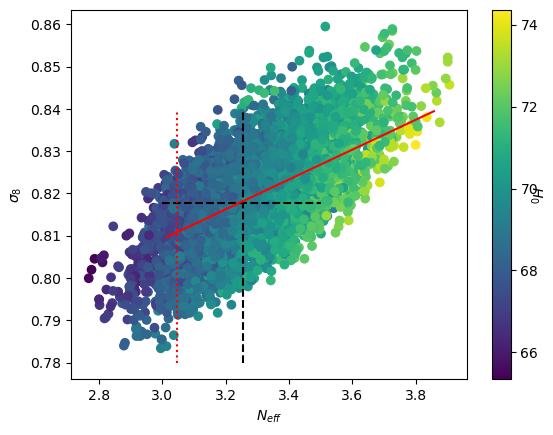

In [20]:
fig, ax = plt.subplots()

scatter = ax.scatter(N_eff,sigma8, c=H0)
ax.plot(np.linspace(3,3.5,2), [0.8177118,0.8177118],"k--")
ax.plot([0.3256184E+01,0.3256184E+01], np.linspace(0.78,0.84,2),"k--")
ax.plot([0.3046E+01,0.3046E+01], np.linspace(0.78,0.84,2),"r:")
ax.plot(line[:, 0], line[:, 2], 'r')
ax.set_xlabel(r"$N_{eff}$")
ax.set_ylabel(r"$\sigma_{8}$")
cbar = fig.colorbar(scatter)
cbar.set_label(r'$H_0$', rotation=270)

/tmp/ipykernel_85243/4243573724.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


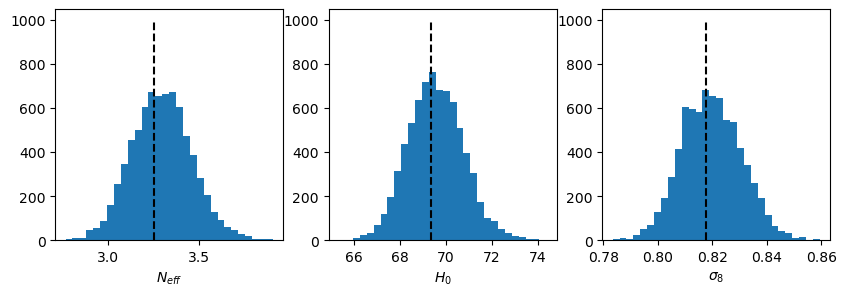

In [21]:
fig, ax = plt.subplots(1,3, figsize = (10,3))

ax[0].hist(N_eff, bins=30)
ax[0].set_xlabel(r"$N_{eff}$")
ax[0].plot([0.3256184E+01,0.3256184E+01], [0,1000],"k--")
ax[1].hist(H0, bins=30)
ax[1].plot([0.6933350E+02,0.6933350E+02], [0,1000],"k--")
ax[1].set_xlabel(r"$H_0$")
ax[2].hist(sigma8, bins=30)
ax[2].set_xlabel(r"$\sigma_8$")
ax[2].plot([0.8177118,0.8177118], [0,1000],"k--")

fig.show()

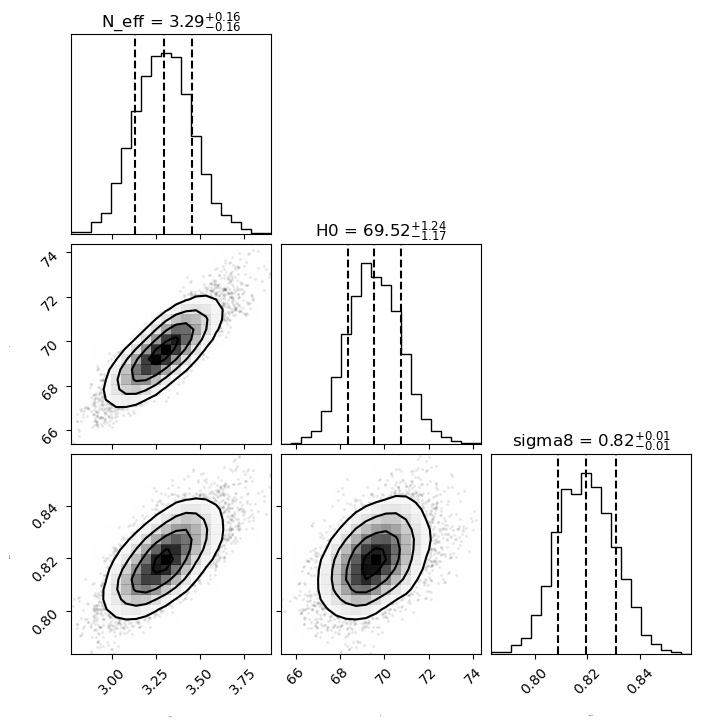

In [22]:
flat_samples = np.array([N_eff,H0,sigma8]).T
fig = corner.corner(
    flat_samples, labels=["N_eff","H0","sigma8"], show_titles=True, quantiles=[0.16, 0.50, 0.84],
                    label_kwargs={'labelpad':20, 'fontsize':0}, fontsize=8, smooth = True
);

[[0.1163329  0.9932018  0.00410437]]


Text(0.5, 0, '$\\sigma_8$')

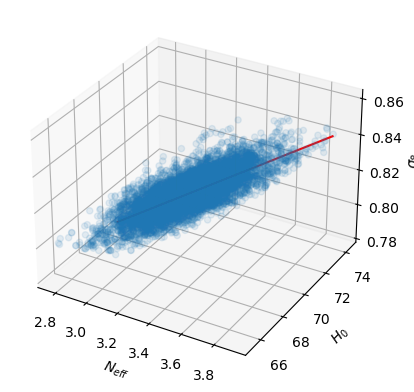

In [10]:
coords = np.array((N_eff, H0, sigma8)).T

pca = PCA(n_components=1)
pca.fit(coords)
direction_vector = pca.components_
print(direction_vector)

# Create plot
origin = np.mean(coords, axis=0)
euclidian_distance = np.linalg.norm(coords - origin, axis=1)
extent = np.max(euclidian_distance)

line = np.vstack((origin - (direction_vector * extent)/2,
                  origin + direction_vector * extent))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(coords[:, 0], coords[:, 1], coords[:,2], alpha =0.1)
ax.plot(line[:, 0], line[:, 1], line[:, 2], 'r')
ax.set_xlabel(r"$N_{eff}$")
ax.set_ylabel(r"$H_{0}$")
ax.set_zlabel(r"$\sigma_8$")

In [26]:
# Background cosmology for pyccl

Omg_r1 = (1 + (7/8) * (4/11)**(4/3)*0.3256184E+01)*2.47282e-5/0.6933350**2
Omg_r_LCDM1 = (1 + (7/8) * (4/11)**(4/3)*3.046)*2.47282e-5/0.6933350**2
cosmo1 = [0.1218179*1e4/0.6933350E+02**2 , 0.2264934E-01*1e4/0.6933350E+02**2, 0 ,Omg_r1 , Omg_r1 - Omg_r_LCDM1]

cosmo = ccl.core.Cosmology(Omega_c=cosmo1[0],
                               Omega_b=cosmo1[1], 
                               A_s=0.2122419e-8,
                               h = 0.6933350,
                               n_s=0.9765129,
                               Omega_k=0,#cosmo[2], 
                               Omega_g=2.47282e-5/0.6933350**2,
                               Neff = 0.3256184E+01,
                               m_nu = 0.6000000E-01
                              )

k = np.logspace(-9,5,150) # in Mpc^-1
# Decide on some coordinate times
x = np.linspace( -20, 0 , 100)
a = np.exp(x)

cosmo_val = [0.1160639*1e4/0.6933350E+02**2 , 0.2241152E-01*1e4/0.6933350E+02**2, 0 ,Omg_r1 , 0]
cosmo_val_alph = cosmo1
soln = solve_for_growth(a, cosmo_val, k*(3e5/100)/cosmo["h"])[0].T
soln_alph = solve_for_growth(a, cosmo_val_alph, k*(3e5/100)/cosmo["h"])[0].T

#sigma8_test = np.zeros(len(a))
#sigma8_test_alph = np.zeros(len(a))

sigma8_test = sc.integrate.trapz(k**2 * soln**2 *ccl.power.linear_matter_power(cosmo, k, 1)*\
                           (3*sc.special.spherical_jn(1, k*8/cosmo["h"], derivative=False)/(k*8/cosmo["h"]))**2,\
                           x=k)/(2*np.pi**2)
sigma8_test_alph = sc.integrate.trapz(k**2 *(soln[find_nearest(a, 1/1101)]/soln_alph[find_nearest(a, 1/1101)])**2 * soln_alph**2 *ccl.power.linear_matter_power(cosmo, k, 1)*\
                           (3*sc.special.spherical_jn(1, k*8/cosmo["h"], derivative=False)/(k*8/cosmo["h"]))**2,\
                           x=k)/(2*np.pi**2)

In [27]:
print(Omg_r1 - 2.47282e-5/0.6933350**2)
print(0.6451439E-03/0.6933350**2)
print((0.6451439E-03/0.6933350**2)/((1 + (7/8) * (4/11)**(4/3)*0.3256184E+01) -1))

3.8040509235182697e-05
0.001342055100134145
0.0018148063113714796


0.0
0.8221277449270554
0.8187287590570979
-0.005371361025465999


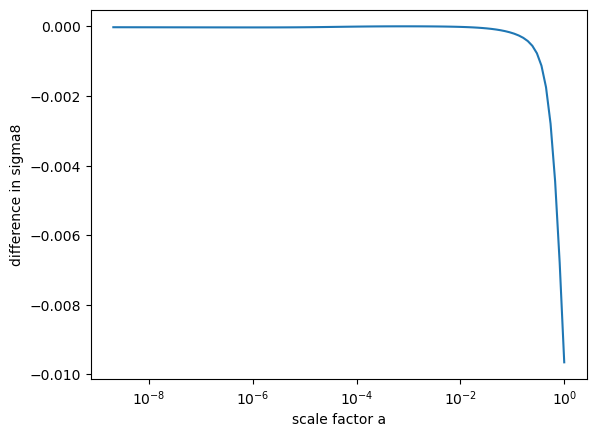

In [28]:
#plt.plot(a,np.sqrt(sigma8_test), color="r", label = "sigma8 LCDM with direct integration")
#plt.plot(a,np.sqrt(sigma8_test_alph), color="b", label = "sigma8 4DEGB with direct integration")
plt.plot(a,-np.sqrt(sigma8_test_alph)+np.sqrt(sigma8_test))
print(-np.sqrt(sigma8_test_alph[find_nearest(a, 1/1101)])+np.sqrt(sigma8_test[find_nearest(a, 1/1101)]))
plt.xscale("log")
plt.xlabel("scale factor a")
plt.ylabel("difference in sigma8")
#plt.yscale("log")
print(np.sqrt(sigma8_test[-1]))
print(ccl.power.sigma8(cosmo))
print((0.8177118-np.sqrt(sigma8_test[-1]))/np.sqrt(sigma8_test[-1]))

In [10]:
# for tests
#N_eff = N_eff[:300]
#sigma8 = sigma8[:300]
#H0 = H0[:300]
# We finf respective cosmologies for N_eff - TODO get correct cosmo params
dN_eff = N_eff - 3.046
Omg_r = (1 + (7/8) * (4/11)**(4/3)*N_eff)*2.47282e-5*1e4/H0**2
Omg_r_LCDM = (1 + (7/8) * (4/11)**(4/3)*3.046)*2.47282e-5*1e4/H0**2
cosmo = [w_c*1e4/H0**2 , w_b*1e4/H0**2, 0 ,Omg_r , Omg_r - Omg_r_LCDM]

# k range over which to integrate
k_val = np.logspace(-9,5,150) # in Mpc^-1 
# Decide on some coordinate times
x_val = np.linspace( -20, 0 , 100)
a_val = np.exp(x_val)
z_val = 1/a_val - 1


In [30]:
# Find the new distribution of N_eff, sigma_8, H0


# find sigma8(z) LCDM, then find sigma8(z_CMB)
#simga8_z_4DEGB = np.zeros((len(N_eff), len(a_val)))
#simga8_z_LCDM = np.zeros((len(N_eff), len(a_val)))


def parallelprocess(i):
    if N_eff[i] > 3.046:
        # Define 4DEGB cosmology
        cosmo_val = [cosmo[0][i] , cosmo[1][i], cosmo[2] ,cosmo[3][i] , cosmo[4][i]]
        cosmoCCL = ccl.core.Cosmology(Omega_c=cosmo[0][i],
                                   Omega_b=cosmo[1][i], 
                                   A_s=A_s[i],
                                   h = H0[i]/100,
                                   n_s=n_s[i],
                                   Omega_k=cosmo[2],
                                   Omega_g=2.47282e-5*1e4/H0[i]**2,
                                   Neff = N_eff[i],
                                   m_nu = 0.6000000E-01
                                  )
        # Define LCDM cosmology
        cosmo_val_LCDM = [cosmo[0][i] , cosmo[1][i], cosmo[2] ,cosmo[3][i] , 0]
        # find soln 4DEGB
        soln = solve_for_growth(a_val, cosmo_val, k_val*(3e5/100)/cosmoCCL["h"])[0].T
        # find soln LCDM
        soln_LCDM = solve_for_growth(a_val, cosmo_val_LCDM, k_val*(3e5/100)/cosmoCCL["h"])[0].T
        # find sigma_8 predicted for 4DEGB and for LCDM (for comparison)
        return np.array([sc.integrate.trapz(k_val**2 *(soln_LCDM[find_nearest(a_val, 1/1101)]/soln[find_nearest(a_val, 1/1101)])**2* soln**2 *ccl.power.linear_matter_power(cosmoCCL, k_val, 1)*\
                               (3*sc.special.spherical_jn(1, k_val*8/cosmoCCL["h"], derivative=False)/(k_val*8/cosmoCCL["h"]))**2,\
                               x=k_val)/(2*np.pi**2),
                     sc.integrate.trapz(k_val**2 * soln_LCDM**2 *ccl.power.linear_matter_power(cosmoCCL, k_val, 1)*\
                               (3*sc.special.spherical_jn(1, k_val*8/cosmoCCL["h"], derivative=False)/(k_val*8/cosmoCCL["h"]))**2,\
                               x=k_val)/(2*np.pi**2)])
    
results = Parallel(n_jobs=7)(delayed(parallelprocess)(i) for i in tqdm(range(len(N_eff))))

#    plt.plot(a_val,simga8_z_LCDM)
#    plt.plot(a_val,simga8_z_4DEGB)
#plt.xscale("log")



  0%|                                                  | 0/7558 [00:00<?, ?it/s]/home/c2042999/anaconda3/envs/4DEGB_venv2/lib/python3.9/site-packages/pyccl/core.py:736: CCLWarning: CCL does not properly compute the linear growth rate in cosmological models with massive neutrinos!
  warnings.warn(
/home/c2042999/anaconda3/envs/4DEGB_venv2/lib/python3.9/site-packages/pyccl/core.py:736: CCLWarning: CCL does not properly compute the linear growth rate in cosmological models with massive neutrinos!
  warnings.warn(
/home/c2042999/anaconda3/envs/4DEGB_venv2/lib/python3.9/site-packages/pyccl/core.py:736: CCLWarning: CCL does not properly compute the linear growth rate in cosmological models with massive neutrinos!
  warnings.warn(
/home/c2042999/anaconda3/envs/4DEGB_venv2/lib/python3.9/site-packages/pyccl/core.py:736: CCLWarning: CCL does not properly compute the linear growth rate in cosmological models with massive neutrinos!
  warnings.warn(
/home/c2042999/anaconda3/envs/4DEGB_venv2/lib/

In [23]:
# extract sigma_8 predicted for 4DEGB and for LCDM 

# do this to remove all the "None" entries
#for i in range(len(results)):
#    if hasattr(results[i], "__len__") == False:
#        del results[i]
#print(len(results))



#np.savetxt('sigma8_LCDM_computed.txt', np.array(results)[:,1,-1], fmt='%s')
#np.savetxt('sigma8_4DEGB_computed.txt', np.array(results)[:,0,-1], fmt='%s')


simga8_z_LCDM = np.sqrt(np.loadtxt('sigma8_LCDM_computed.txt'))
simga8_z_4DEGB = np.sqrt(np.loadtxt('sigma8_4DEGB_computed.txt'))
print(len(simga8_z_LCDM))


#print(len(np.transpose(np.array(results), axes = 1)))
#print(len(results[0][0]))
#np.savetxt("sigma8_4DEGB_LCDM_cclandintegral.txt", np.array(results), fmt='%s')

7102


In [24]:
# find positions at which None occurs
count = 0
row = 0
c2 = 0
zeros_pos = np.zeros(456, dtype = int)
value_test = open("sigma8_4DEGB_LCDM_cclandintegral.txt").read()
for i in range(len(value_test)):
    if value_test[i]  == "[":
        count +=1
        row = int(count/3)
    if value_test[i]  == "N":
        #print(row)
        zeros_pos[c2] = row
        c2+=1
        count +=3
        row = int(count/3)
# removing all values that returned none

N_eff_cut = np.zeros(len(N_eff))
H0_cut = np.zeros(len(N_eff))
w_b_cut = np.zeros(len(N_eff))
w_c_cut = np.zeros(len(N_eff))
sigma8_cut = np.zeros(len(N_eff))
Omega_m_Planck_cut = np.zeros(len(N_eff))
A_s_cut = np.zeros(len(N_eff))
n_s_cut = np.zeros(len(N_eff))

for i in range(len(N_eff)):
    if i not in zeros_pos:
        N_eff_cut[i] = N_eff[i]
        H0_cut[i] = H0[i]
        w_b_cut[i] = w_b[i]
        w_c_cut[i] = w_c[i]
        sigma8_cut[i] = sigma8[i]
        Omega_m_Planck_cut[i] = Omega_m_Planck[i]
        A_s_cut[i] = A_s[i]
        n_s_cut[i] = n_s[i]


N_eff_cut = N_eff_cut[N_eff_cut != 0]
H0_cut = H0_cut[H0_cut != 0]
w_b_cut = w_b_cut[w_b_cut != 0]
w_c_cut = w_c_cut[w_c_cut != 0]
sigma8_cut = sigma8_cut[sigma8_cut != 0]
Omega_m_Planck_cut = Omega_m_Planck_cut[Omega_m_Planck_cut != 0]
A_s_cut = A_s_cut[A_s_cut != 0]
n_s_cut = n_s_cut[n_s_cut != 0]


In [25]:
# find sigma_8 predicted from CCL

Omg_r_cut = (1 + (7/8) * (4/11)**(4/3)*N_eff_cut)*2.47282e-5*1e4/H0_cut**2
Omg_r_LCDM_cut = (1 + (7/8) * (4/11)**(4/3)*3.046)*2.47282e-5*1e4/H0_cut**2
cosmo_cut = [w_c_cut*1e4/H0_cut**2 , w_b_cut*1e4/H0_cut**2, 0 ,Omg_r_cut , Omg_r_cut - Omg_r_LCDM_cut]

sigma_8CCL = np.zeros(len(N_eff))
for i in range(1100):
    if N_eff_cut[i] > 3.046:
        cosmoCCL = ccl.core.Cosmology(Omega_c=cosmo_cut[0][i],
                                   Omega_b=cosmo_cut[1][i], 
                                   A_s=A_s_cut[i],
                                   h = H0_cut[i]/100,
                                   n_s=n_s_cut[i],
                                   Omega_k=cosmo_cut[2],
                                   Omega_g=2.47282e-5*1e4/H0_cut[i]**2,
                                   Neff = N_eff_cut[i],
                                   m_nu = 0.6000000E-01
                                  )
        sigma_8CCL[i] = ccl.power.sigma8(cosmoCCL)


/home/c2042999/anaconda3/envs/4DEGB_venv2/lib/python3.9/site-packages/pyccl/core.py:736: CCLWarning: CCL does not properly compute the linear growth rate in cosmological models with massive neutrinos!
  warnings.warn(


7558
7102


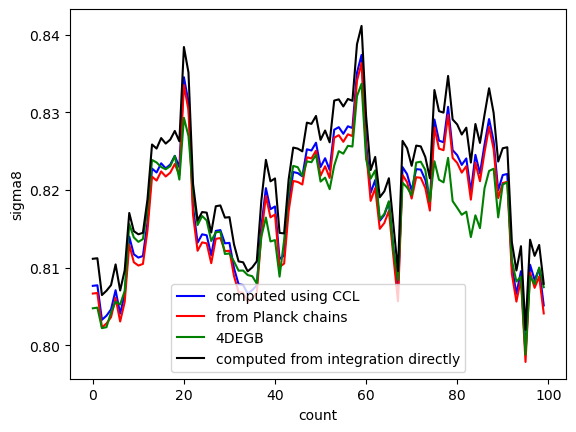

In [27]:
print(len(sigma8))
print(len(sigma8_cut))
plt.plot(sigma_8CCL[:100], "b", label = "computed using CCL")
plt.plot(sigma8_cut[:100], "r", label = "from Planck chains")
plt.plot(simga8_z_4DEGB[:100], "g", label = "4DEGB")
plt.plot(simga8_z_LCDM[:100], "k", label = "computed from integration directly")
plt.xlabel("count")
plt.ylabel("sigma8")
plt.legend()
plt.show()

7102
7102


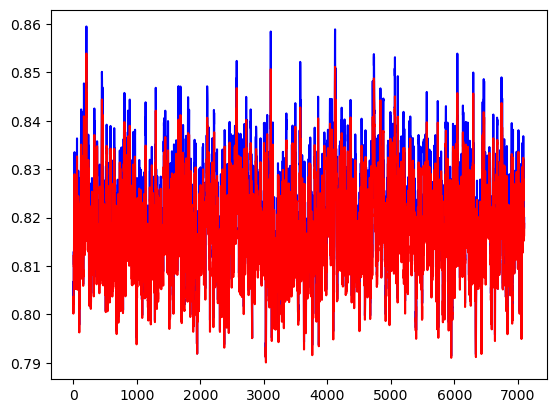

In [32]:
plt.plot(sigma8_cut, "b")
print(len(sigma8_cut))
print(len(simga8_z_4DEGB))
plt.plot(np.sqrt(simga8_z_4DEGB) * sigma8_cut/np.sqrt(simga8_z_LCDM), "r")

7102


Text(0.5, 0, '$\\sigma_8$')

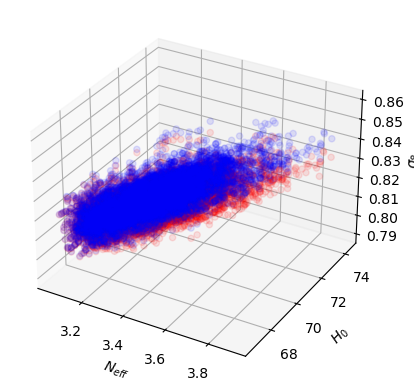

In [30]:
avg_S8 = np.zeros(len(N_eff_cut))
for i in range(len(N_eff_cut)):
    avg_S8[i] = np.sqrt(simga8_z_4DEGB[i])*sigma8_cut[i]/np.sqrt(simga8_z_LCDM[i])
        
print(len(avg_S8))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(N_eff_cut, H0_cut, sigma8_cut, alpha =0.1, color = "b")
ax.scatter(N_eff_cut, H0_cut, avg_S8, alpha =0.1, color = "r")
ax.set_xlabel(r"$N_{eff}$")
ax.set_ylabel(r"$H_{0}$")
ax.set_zlabel(r"$\sigma_8$")

In [31]:
print(avg_S8)

[0.80348327 0.80356344 0.80015632 ... 0.81613885 0.81738679 0.81871412]


/tmp/ipykernel_85243/1395363502.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


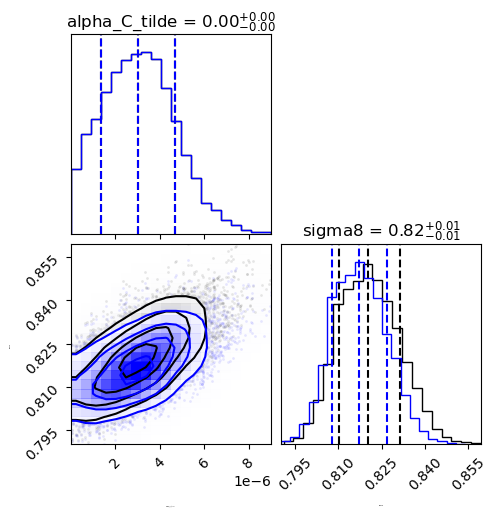

In [32]:
flat_samples = np.array([(Omg_r_cut - Omg_r_LCDM_cut),sigma8_cut]).T
fig = corner.corner(
    flat_samples, labels=["alpha_C_tilde","sigma8"], show_titles=True, quantiles=[0.16, 0.50, 0.84],
                    label_kwargs={'labelpad':20, 'fontsize':0}, fontsize=8, smooth = True
);
flat_samples = np.array([(Omg_r_cut - Omg_r_LCDM_cut),avg_S8]).T

corner.corner(flat_samples,fig=fig, quantiles=[0.16, 0.50, 0.84],
                    label_kwargs={'labelpad':20, 'fontsize':0}, fontsize=8, smooth = True, color = "b")
fig.show()

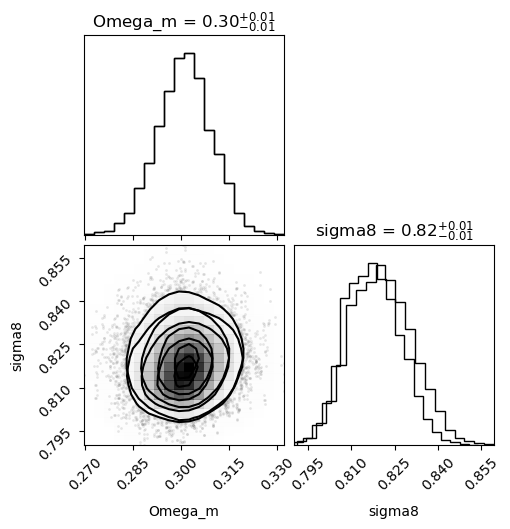

In [33]:
flat_samples = np.array([Omega_m_Planck_cut,sigma8_cut]).T
fig = corner.corner(
    flat_samples, labels=["Omega_m","sigma8"], show_titles=True,  fontsize=8, smooth = True
);

flat_samples = np.array([Omega_m_Planck_cut,avg_S8]).T
corner.corner(flat_samples,fig=fig,  fontsize=8, smooth = True)
plt.show()

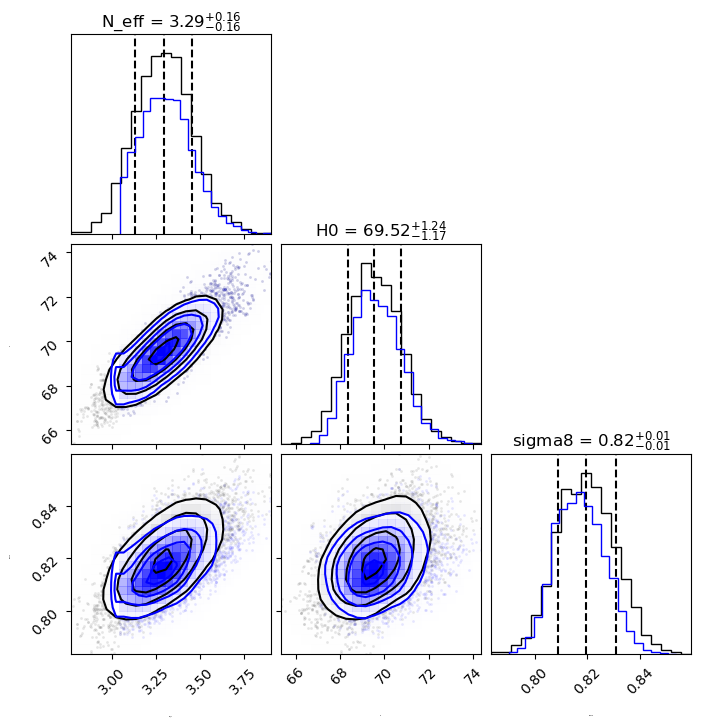

In [34]:
flat_samples = np.array([N_eff,H0,sigma8]).T
fig = corner.corner(
    flat_samples, labels=["N_eff","H0","sigma8"], show_titles=True, quantiles=[0.16, 0.50, 0.84],
                    label_kwargs={'labelpad':20, 'fontsize':0}, fontsize=8, smooth = True
);
flat_samples = np.array([N_eff_cut,H0_cut,avg_S8]).T
corner.corner(flat_samples, fig=fig,  fontsize=8, smooth = True, color="b")
plt.show()

In [225]:
# Import the datafiles for KiDS - probe of late-time growth of structure
content_KiDS = pd.read_table('/home/c2042999/Downloads/KiDS1000_vdB22_cosmic_shear_data_release/multinest/Fid_output_multinest_C.txt', delim_whitespace=True, header=None)

# get data for N_eff, sigma_8 and H_0
sigma_8_KiDS = content_KiDS[13][234:]
sigma_8_KiDS = [float(x) for x in sigma_8_KiDS[:-3]]
Omega_m_KiDS = content_KiDS[15][234:]
Omega_m_KiDS = [float(x) for x in Omega_m_KiDS[:-3]]

print(len(Omega_m_KiDS))
del content_KiDS

14743


/tmp/ipykernel_25727/2665281345.py:6: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  sigma_8_KiDS = [float(x) for x in sigma_8_KiDS[:-3]]
/tmp/ipykernel_25727/2665281345.py:8: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  Omega_m_KiDS = [float(x) for x in Omega_m_KiDS[:-3]]


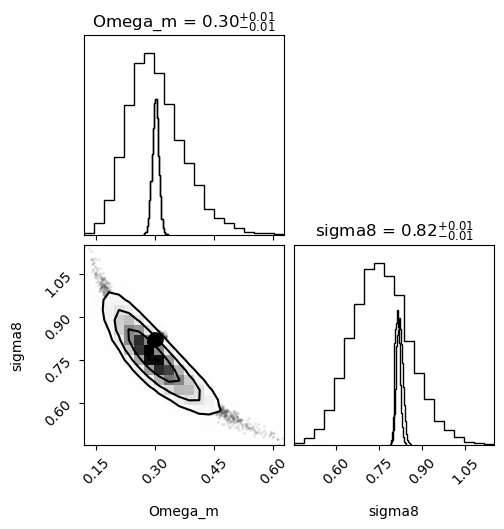

In [227]:
flat_samples = np.array([Omega_m_Planck_cut,sigma8_cut]).T
fig = corner.corner(
    flat_samples, labels=["Omega_m","sigma8"], show_titles=True,  fontsize=8, smooth = True
);

flat_samples = np.array([Omega_m_Planck_cut,avg_S8]).T
corner.corner(flat_samples,fig=fig,  fontsize=8, smooth = True)

flat_samples = np.array([Omega_m_KiDS[-9391:-1],sigma_8_KiDS[-9391:-1]]).T
corner.corner(flat_samples,fig=fig, smooth = True)
plt.show()

# Extra stuff

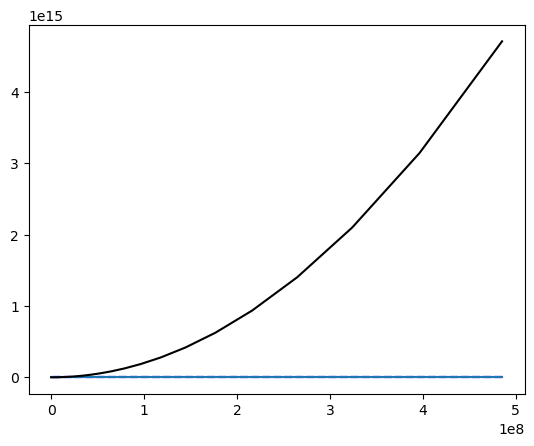

In [14]:
"""Gamma Parametrization - note no k dependence"""
cosmo = [0.27 , 0.045, 0 ,9.227e-5 , 1e-4]
soln1 = solve_for_growth(a_val, cosmo, [0.001*(3e5/100),0.001*(3e5/100)])
plt.plot(z_val,np.log(soln1[1][1])/np.log((cosmo[0]+cosmo[1])*(1+z_val)**3\
                      *a_val**4/ Easquared(a_val,cosmo)**2),"b--")
cosmo = [0.27 , 0.045, 0 ,9.227e-5 , 1e-5]
soln1 = solve_for_growth(a_val, cosmo, [0.001*(3e5/100),0.001*(3e5/100)])
plt.plot(z_val,np.log(soln1[1][1])/np.log((cosmo[0]+cosmo[1])*(1+z_val)**3\
                      *a_val**4/ Easquared(a_val,cosmo)**2),"b--")
cosmo = [0.27 , 0.045, 0 ,9.227e-5 , 1e-6]
soln1 = solve_for_growth(a_val, cosmo, [0.001*(3e5/100),0.001*(3e5/100)])
plt.plot(z_val,np.log(soln1[1][1])/np.log((cosmo[0]+cosmo[1])*(1+z_val)**3\
                      *a_val**4/ Easquared(a_val,cosmo)**2),"b--")

plt.plot(z_val,np.log(solution_growth_LCDM[1][-1])/np.log((cosmo[0]+cosmo[1])*(1+z_val)**3\
                      *a_val**4/ Easquared(a_val,cosmo_LCDM_array)**2))
plt.plot(z_val,0.02*z_val**2 + 0.55,"k")
#plt.plot(z_val,np.log(solution_growth_LCDM[1][-1])/np.log((cosmo[0]+cosmo[1])*(1+z_val)**3))
#plt.plot(z_val,ccl.growth_rate(cosmoLCDM,a_val))
#plt.plot(z_val, ((cosmo[0]+cosmo[1])*(1+z_val)**3 \
#                 *a_val**4/ Easquared(a_val,cosmo)**2)**(0.55))

#plt.ylim(0.5,12)

Text(0, 0.5, 'growth factor')

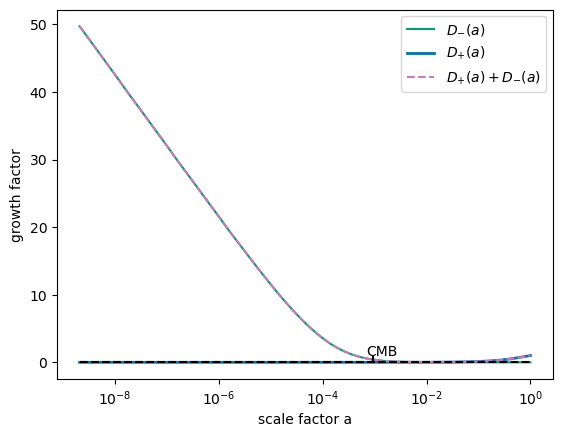

In [15]:
# TRY SOMETHING WITH THE DECAYING MODE INCLUDED

D = solve_for_growth(a_val, cosmo_LCDM_array, [1,1])[0]
def bc_var(ya, yb):
    return np.array([ya[0]-1, yb[0]])

def solve_for_growth_decay(a, cosmo, k):
    
    # x range over which to solve fun
    x = np.logspace(-99,0,100)
    # initial guess for value of functions (y_init = [y[0]_init,y[0]_init])
    y_init = np.zeros((2, x.size))
    y_init[0] = x
    D_val = np.zeros((len(k),len(a)))
    f_val = np.zeros((len(k),len(a)))
    for i in range(len(k)):
        soln = solve_bvp(lambda x, y: solverGrowth(x, y, cosmo, k[i]), bc_var, x, y_init).sol(a)
        D_val[i] = soln[0]
        a3EDdot = soln[1]
        f_val[i] = a3EDdot/(D_val[i]*Easquared(a,cosmo))
    return D_val, f_val

D_decay = solve_for_growth_decay(a_val, cosmo_LCDM_array, [1,1])[0]
plt.plot(a_val,1e3*D_decay[0], color = col[2], label = r"$D_{-}(a)$")
plt.plot(a_val,D[0], label = r"$D_{+}(a)$", color = col[0], linewidth=2)
plt.plot(a_val,D[0]+1e3*D_decay[0], "--",color = col[4],label = r"$D_{+}(a) + D_{-}(a)$")
plt.plot(np.ones(100)/1101,np.linspace(0,1,100), "k--")
plt.plot(a_val, np.zeros(len(a_val)), "k--")
plt.text(0.0007, 1.0, "CMB")

plt.xscale("log")
plt.legend()
plt.xlabel("scale factor a")
plt.ylabel(r"growth factor")